In [322]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [323]:
df_diabetes = pd.read_csv('.\\data\\diabetic_data.csv')

In [324]:
df_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

### TRATAMIENTO DE MISING VALUES Y ANALISIS DE NULOS

In [325]:
df_diabetes.replace('?', np.nan, inplace=True)

missing_data = df_diabetes.isnull().sum()
missing_percentage = (missing_data / df_diabetes.size) * 100

missing_info = pd.DataFrame({
    'Missing Values': missing_data,
    'Percentage': missing_percentage
})

print(missing_info)

                          Missing Values  Percentage
encounter_id                           0    0.000000
patient_nbr                            0    0.000000
race                                2273    0.044671
gender                                 0    0.000000
age                                    0    0.000000
weight                             98569    1.937170
admission_type_id                      0    0.000000
discharge_disposition_id               0    0.000000
admission_source_id                    0    0.000000
time_in_hospital                       0    0.000000
payer_code                         40256    0.791148
medical_specialty                  49949    0.981644
num_lab_procedures                     0    0.000000
num_procedures                         0    0.000000
num_medications                        0    0.000000
number_outpatient                      0    0.000000
number_emergency                       0    0.000000
number_inpatient                       0    0.

Se toma la decisión de eliminar las columnas con presencia de nulos mayor a 5% y mantener las columnas con nulos menores a ese umbral pero eliminar las filas nulas de estas variables.

Columnas a eliminar:
- weight
- payer_code
- medical_specialty
- max_glu_serum
- A1Cresult

In [326]:
threshold_column = 0.05
columns_to_drop = missing_info[missing_info['Percentage'] > threshold_column].index
df_diabetes_cleaned_columns = df_diabetes.drop(columns=columns_to_drop)

threshold_row = 0.05
rows_to_drop = missing_info[missing_info['Percentage'] < threshold_row].index
df_diabetes_cleaned = df_diabetes_cleaned_columns.dropna(subset=rows_to_drop)

print("Shape del DataFrame después de limpiar:", df_diabetes_cleaned.shape)
print(df_diabetes_cleaned.info())

Shape del DataFrame después de limpiar: (98053, 45)
<class 'pandas.core.frame.DataFrame'>
Index: 98053 entries, 1 to 101765
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              98053 non-null  int64 
 1   patient_nbr               98053 non-null  int64 
 2   race                      98053 non-null  object
 3   gender                    98053 non-null  object
 4   age                       98053 non-null  object
 5   admission_type_id         98053 non-null  int64 
 6   discharge_disposition_id  98053 non-null  int64 
 7   admission_source_id       98053 non-null  int64 
 8   time_in_hospital          98053 non-null  int64 
 9   num_lab_procedures        98053 non-null  int64 
 10  num_procedures            98053 non-null  int64 
 11  num_medications           98053 non-null  int64 
 12  number_outpatient         98053 non-null  int64 
 13  number_emergency          98

#### TARGET

In [327]:
readmitted_unique = df_diabetes_cleaned['readmitted'].unique()
print(readmitted_unique)

['>30' 'NO' '<30']


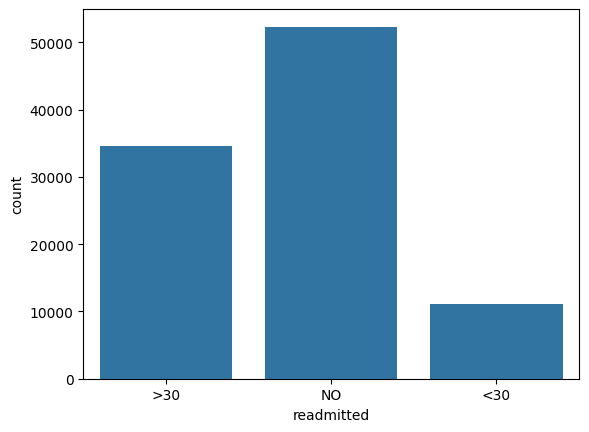

In [328]:
sns.countplot(x='readmitted', data=df_diabetes_cleaned)
plt.show()

La variable objetivo muestra un desbalance de clases lo cual implica que pueda ser necesario aplicar alguna tecninca de balanceo de clases como SMOTE.

In [329]:
target_count = df_diabetes_cleaned['readmitted'].value_counts()
target_count

readmitted
NO     52338
>30    34649
<30    11066
Name: count, dtype: int64

Se decide mapear la variable objetivo

In [330]:
readmitted_mapping = {'NO': 1, '>30': 2, '<30': 3}
df_diabetes_cleaned['readmitted_mapped'] = df_diabetes_cleaned['readmitted'].map(readmitted_mapping)

C:\Users\marti\AppData\Local\Temp\ipykernel_14412\1588019345.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diabetes_cleaned['readmitted_mapped'] = df_diabetes_cleaned['readmitted'].map(readmitted_mapping)


#### VARIABLES NUMERICAS

In [331]:
var_numericas = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 
                    'number_inpatient', 'number_diagnoses']

#### VARIABLES CATEGORICAS

In [332]:
var_persona = ['race', 'gender', 'age']
var_medicas = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_2', 'diag_3']
var_medicine = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 
                'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide',
                'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 
                'metformin-rosiglitazone', 'metformin-pioglitazone''change', 'diabetesMed']


#### ANALISIS DE VARIABLES NUMERICAS

In [333]:
df_diabetes_cleaned[var_numericas].describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,98053.000000,98053.000000,98053.000000,98053.000000,98053.000000,98053.000000,98053.000000,98053.000000
mean,4.421976,43.148073,1.350749,16.119650,0.376378,0.202462,0.646864,7.512060
std,2.993074,19.712033,1.708506,8.108476,1.283359,0.942892,1.271020,1.832497
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000
25%,2.000000,31.000000,0.000000,11.000000,0.000000,0.000000,0.000000,6.000000
50%,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


Se genera matriz de correlación para determinar si existen relaciones altas entre variables numericas.
Se utilizan lso metodos "pearson" y "spearman" para comparar resultados
Se detecta que hay una correlación de 0.47 entre "num_medications" y "time_in_hospital" pero se decide avanzar con ambas variables. Se tendrá en cuenta este hecho en caso de que afecte a la performance del modelo.

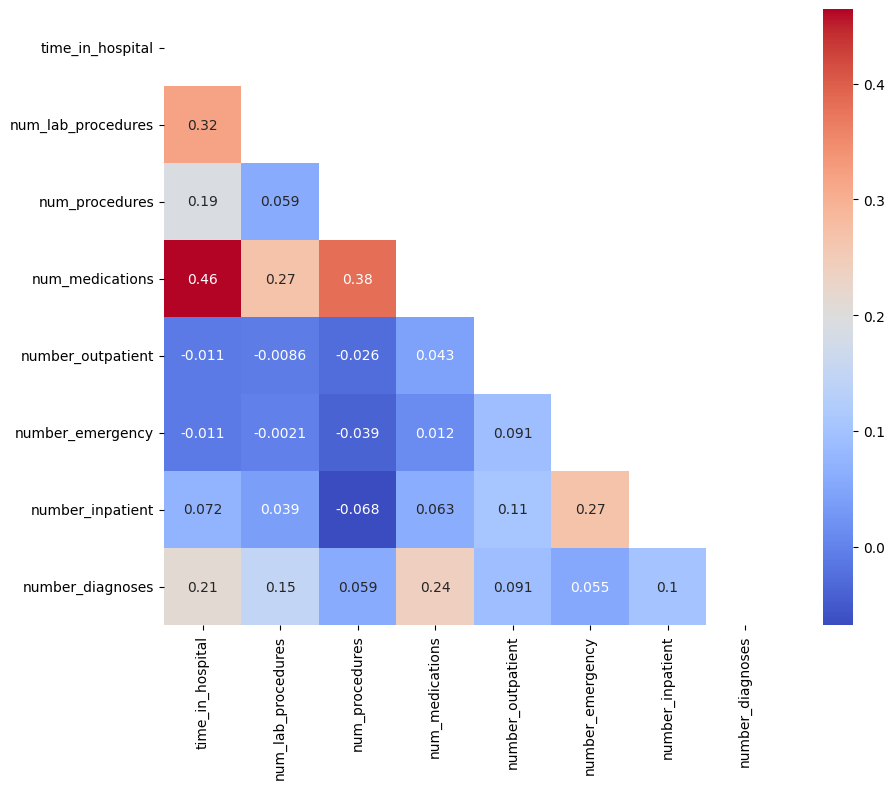

In [334]:
corr_pearson = df_diabetes_cleaned[var_numericas].corr(method='pearson')
mask = np.triu(np.ones_like(corr_pearson, dtype=bool))
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_pearson, annot=True, cmap='coolwarm', ax=ax, mask=mask)
plt.show()

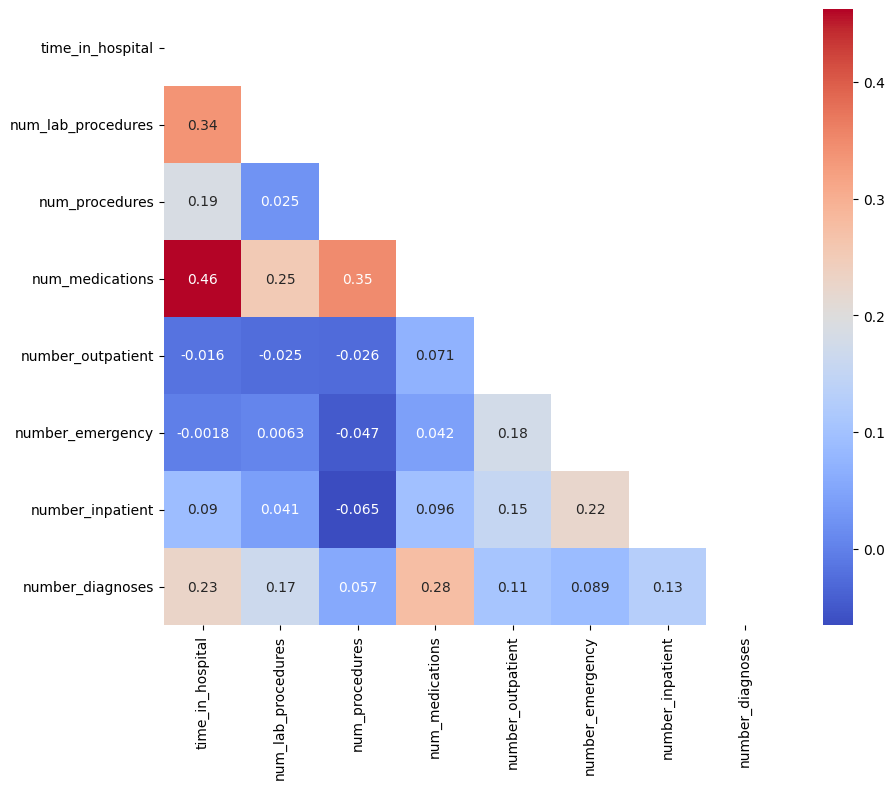

In [335]:
corr_spearman = df_diabetes_cleaned[var_numericas].corr(method='spearman')
mask = np.triu(np.ones_like(corr_spearman, dtype=bool))
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', ax=ax, mask=mask)
plt.show()


Se analiza que variables numericas tienen mas correlacion con la variable a predecir.

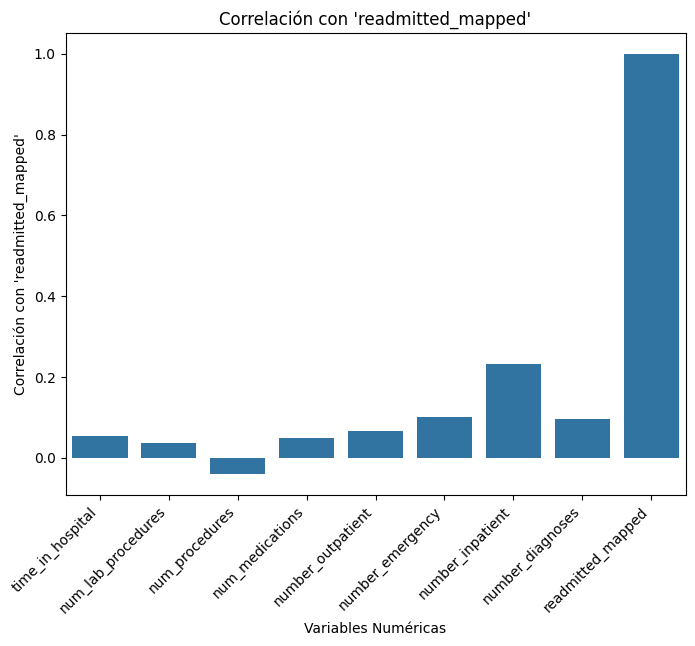

In [336]:
df_numeric = df_diabetes_cleaned[var_numericas].select_dtypes(include=['int64', 'float64'])
df_numeric['readmitted_mapped'] = df_diabetes_cleaned['readmitted_mapped']
correlation_with_readmitted = df_numeric.corr()['readmitted_mapped']

correlation_with_readmitted = df_numeric.corr()['readmitted_mapped']

plt.figure(figsize=(8, 6))
sns.barplot(x=correlation_with_readmitted.index, y=correlation_with_readmitted.values)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Variables Numéricas")
plt.ylabel("Correlación con 'readmitted_mapped'")
plt.title("Correlación con 'readmitted_mapped'")
plt.show()

In [337]:
sorted_correlation = correlation_with_readmitted.sort_values(ascending=False)

print("Correlación con 'readmitted_mapped' (ordenadas de mayor a menor):")
print(sorted_correlation)

Correlación con 'readmitted_mapped' (ordenadas de mayor a menor):
readmitted_mapped     1.000000
number_inpatient      0.232208
number_emergency      0.102011
number_diagnoses      0.097494
number_outpatient     0.066619
time_in_hospital      0.055538
num_medications       0.048782
num_lab_procedures    0.036404
num_procedures       -0.039178
Name: readmitted_mapped, dtype: float64


### VARIABLES CATEGORICAS

##### Analisis *var_persona*

In [338]:
var_persona = ['race', 'gender', 'age']

In [339]:
for variable in var_persona:
    print(f"\nDistribución de valores para '{variable}':")
    print(df_diabetes_cleaned[variable].value_counts(normalize=True))


Distribución de valores para 'race':
race
Caucasian          0.765698
AfricanAmerican    0.192559
Hispanic           0.020234
Other              0.015135
Asian              0.006374
Name: proportion, dtype: float64

Distribución de valores para 'gender':
gender
Female             0.538821
Male               0.461169
Unknown/Invalid    0.000010
Name: proportion, dtype: float64

Distribución de valores para 'age':
age
[70-80)     0.258085
[60-70)     0.222421
[80-90)     0.170336
[50-60)     0.170285
[40-50)     0.094490
[30-40)     0.036185
[90-100)    0.027710
[20-30)     0.015073
[10-20)     0.004753
[0-10)      0.000663
Name: proportion, dtype: float64


Se elimina la row 'Unknown/Invalid' de la variable 'gender' ya que no aporta información y son solamente 2 datos.

In [340]:
count_unknown_invalid = df_diabetes_cleaned['gender'].value_counts().get('Unknown/Invalid', 0)
print(count_unknown_invalid)

1


In [341]:
df_diabetes_cleaned = df_diabetes_cleaned.drop(df_diabetes_cleaned[df_diabetes_cleaned['gender'] == 'Unknown/Invalid'].index)

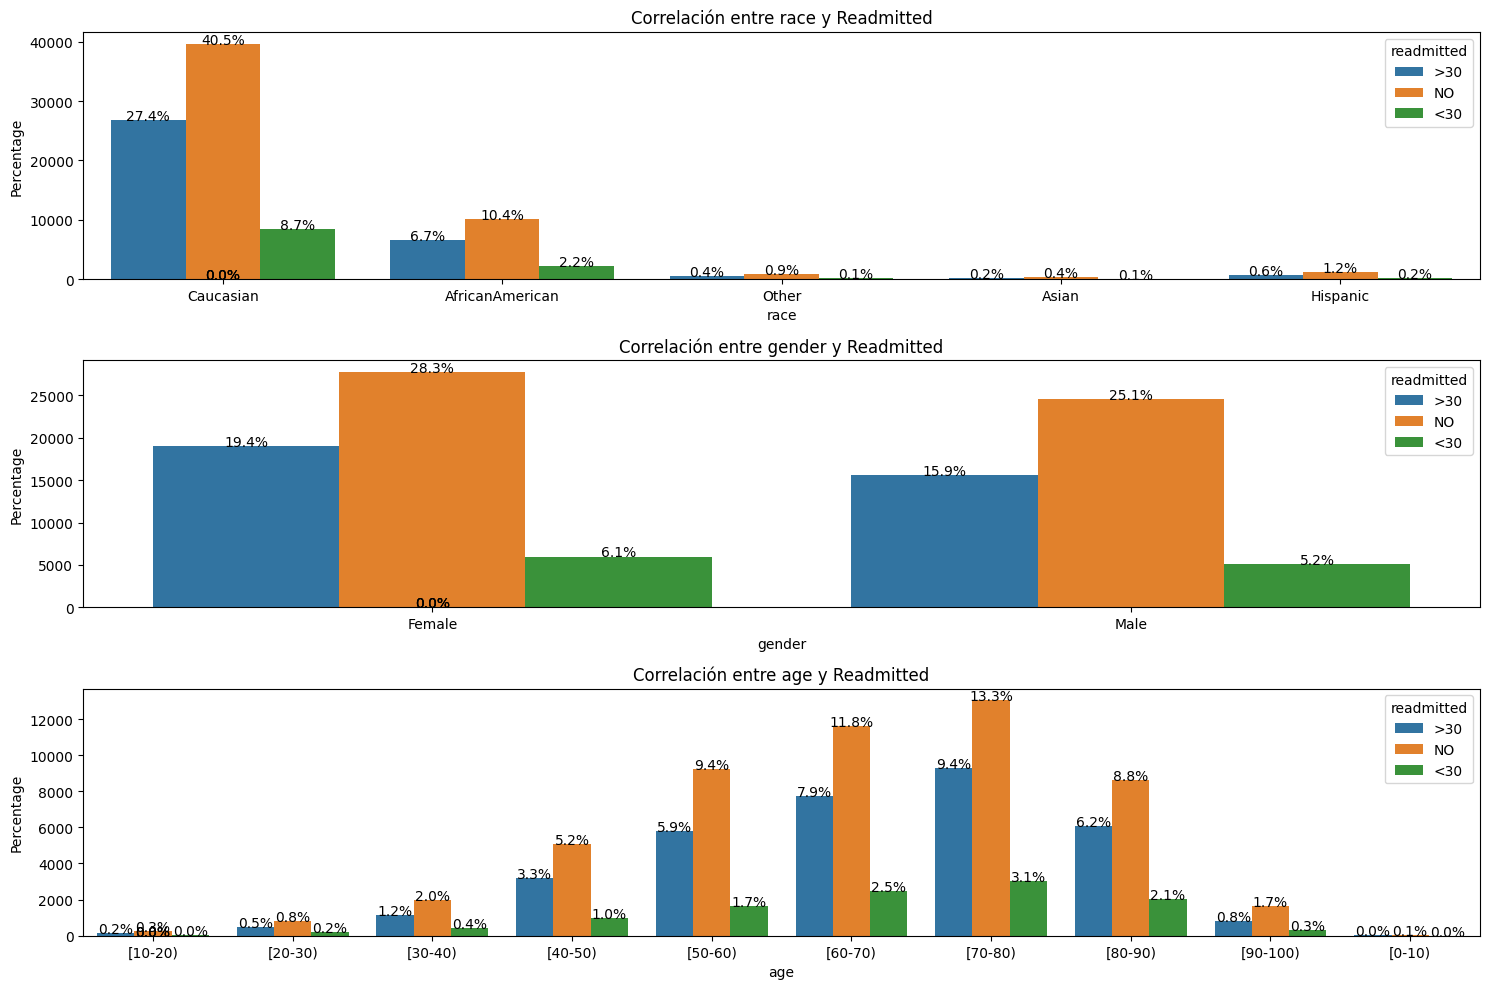

In [342]:
plt.figure(figsize=(15, 10))

for var in var_persona:
    plt.subplot(3, 1, var_persona.index(var) + 1)
    ax = sns.countplot(x=var, hue='readmitted', data=df_diabetes_cleaned, dodge=True) 
    plt.title(f'Correlación entre {var} y Readmitted')
    plt.xlabel(var)
    plt.ylabel('Percentage') 

    total = len(df_diabetes_cleaned[var])
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 3, f'{height / total:.1%}', ha="center")

plt.tight_layout()
plt.show()


##### Analisis *var_medicas*

In [343]:
var_medicas = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_2', 'diag_3']

In [344]:
df_diabetes_cleaned['admission_type_id'].value_counts(normalize=True)

admission_type_id
1    0.532146
3    0.185544
2    0.178915
6    0.052370
5    0.047536
8    0.003182
7    0.000204
4    0.000102
Name: proportion, dtype: float64

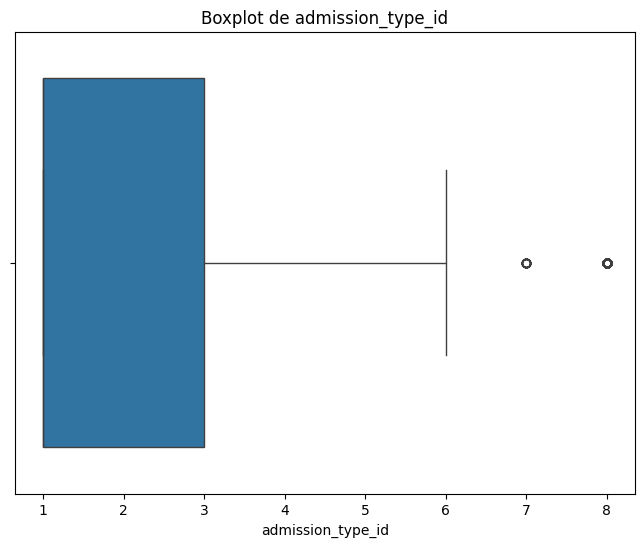

Q1: 1.0, Q3: 3.0, IQR: 2.0
Valores atípicos:
        encounter_id  patient_nbr             race  gender       age  \
7789        36234528     88040709  AfricanAmerican  Female   [60-70)   
8080        37183128     67488210  AfricanAmerican    Male   [50-60)   
8387        38036016     66182823        Caucasian  Female   [70-80)   
8718        39060678     90506502        Caucasian  Female   [50-60)   
8759        39142686     92729475        Caucasian    Male   [60-70)   
...              ...          ...              ...     ...       ...   
99507      414312614     55774188        Caucasian  Female  [90-100)   
100053     420802142    170447693        Caucasian    Male   [60-70)   
100742     430193132     70095330        Caucasian    Male   [80-90)   
100811     431339666    184871975        Caucasian    Male   [50-60)   
100867     431986772      3982338        Caucasian  Female   [70-80)   

        admission_type_id  discharge_disposition_id  admission_source_id  \
7789          

C:\Users\marti\AppData\Local\Temp\ipykernel_14412\3251174675.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers = df_diabetes_cleaned[(df_diabetes['admission_type_id'] < lower_limit) | (df_diabetes_cleaned['admission_type_id'] > upper_limit)]


In [345]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_diabetes_cleaned['admission_type_id'])
plt.title('Boxplot de admission_type_id')
plt.show()

Q1 = df_diabetes_cleaned['admission_type_id'].quantile(0.25)
Q3 = df_diabetes_cleaned['admission_type_id'].quantile(0.75)
IQR = Q3 - Q1

print(f'Q1: {Q1}, Q3: {Q3}, IQR: {IQR}')

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

outliers = df_diabetes_cleaned[(df_diabetes['admission_type_id'] < lower_limit) | (df_diabetes_cleaned['admission_type_id'] > upper_limit)]
print('Valores atípicos:')
print(outliers)


*Se decide eliminar los outliers de la variable 'admission_type_id'*


*Al quitar el outlier "8" el modelo performa peor, por lo cual se decide mantenerlo.*

In [346]:
df_diabetes_cleaned = df_diabetes_cleaned.drop(df_diabetes_cleaned[df_diabetes_cleaned['admission_type_id'] == 7].index)
#df_diabetes_cleaned = df_diabetes_cleaned.drop(df_diabetes_cleaned[df_diabetes_cleaned['admission_type_id'] == 8].index)
df_diabetes_cleaned = df_diabetes_cleaned.drop(df_diabetes_cleaned[df_diabetes_cleaned['admission_type_id'] == 4].index)

In [347]:
df_diabetes_cleaned['discharge_disposition_id'].value_counts(normalize=True)

discharge_disposition_id
1     0.587603
3     0.138326
6     0.128736
18    0.036971
2     0.020893
22    0.020067
11    0.016353
5     0.011497
25    0.009600
4     0.007713
7     0.006039
23    0.004081
13    0.004040
14    0.003754
28    0.001398
8     0.001081
15    0.000643
24    0.000490
9     0.000214
17    0.000143
16    0.000112
19    0.000082
10    0.000061
27    0.000051
12    0.000031
20    0.000020
Name: proportion, dtype: float64

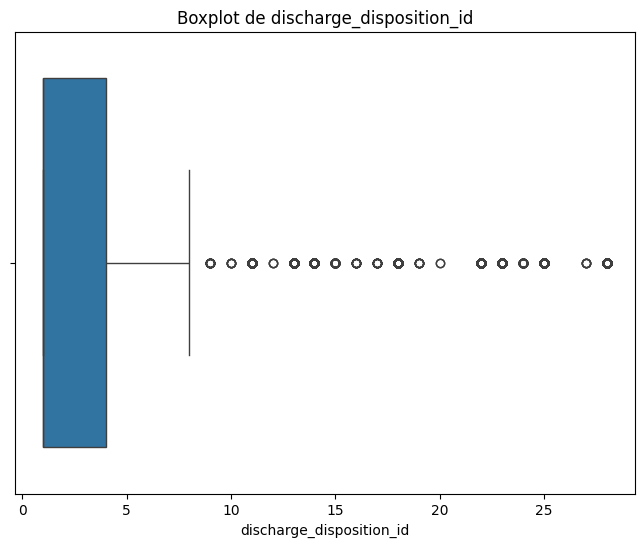

Q1: 1.0, Q3: 6.0, IQR: 5.0


In [348]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_diabetes_cleaned['discharge_disposition_id'])
plt.title('Boxplot de discharge_disposition_id')
plt.show()

Q1 = df_diabetes_cleaned['discharge_disposition_id'].quantile(0.25)
Q3 = df_diabetes_cleaned['discharge_disposition_id'].quantile(0.85)
IQR = Q3 - Q1

print(f'Q1: {Q1}, Q3: {Q3}, IQR: {IQR}')

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

outliers = df_diabetes_cleaned[(df_diabetes_cleaned['discharge_disposition_id'] < lower_limit) | (df_diabetes_cleaned['discharge_disposition_id'] > upper_limit)]

In [349]:
outliers.shape[0]

7588

Se dan de baja las variables con menos de 0.1% de ocurrencia

In [350]:
values_to_drop = df_diabetes_cleaned['discharge_disposition_id'].value_counts(normalize=True)[df_diabetes_cleaned['discharge_disposition_id'].value_counts(normalize=True) < 0.001].index

df_diabetes_cleaned = df_diabetes_cleaned[~df_diabetes_cleaned['discharge_disposition_id'].isin(values_to_drop)]


In [351]:
df_diabetes_cleaned['admission_source_id'].value_counts(normalize=True)

admission_source_id
7     0.570875
1     0.289020
17    0.067211
4     0.030049
6     0.019348
2     0.010497
5     0.008626
3     0.001829
20    0.001635
9     0.000501
8     0.000153
22    0.000123
10    0.000072
11    0.000020
25    0.000020
14    0.000010
13    0.000010
Name: proportion, dtype: float64

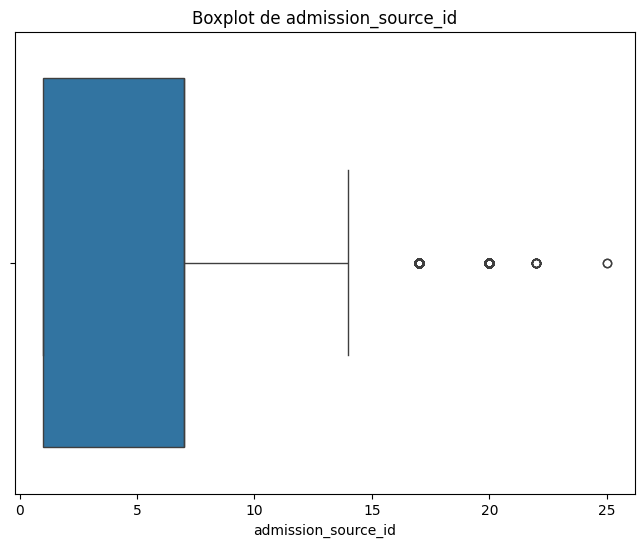

Q1: 1.0, Q3: 7.0, IQR: 6.0


In [352]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_diabetes_cleaned['admission_source_id'])
plt.title('Boxplot de admission_source_id')
plt.show()

Q1 = df_diabetes_cleaned['admission_source_id'].quantile(0.25)
Q3 = df_diabetes_cleaned['admission_source_id'].quantile(0.85)
IQR = Q3 - Q1

print(f'Q1: {Q1}, Q3: {Q3}, IQR: {IQR}')

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

outliers_adm = df_diabetes_cleaned[(df_diabetes_cleaned['admission_source_id'] < lower_limit) | (df_diabetes_cleaned['admission_source_id'] > upper_limit)]

In [353]:
df_diabetes_cleaned['diag_1'].value_counts(normalize=True)

diag_1
428    0.068662
414    0.065116
786    0.039840
410    0.035895
486    0.034720
         ...   
216    0.000010
V43    0.000010
838    0.000010
955    0.000010
V51    0.000010
Name: proportion, Length: 712, dtype: float64

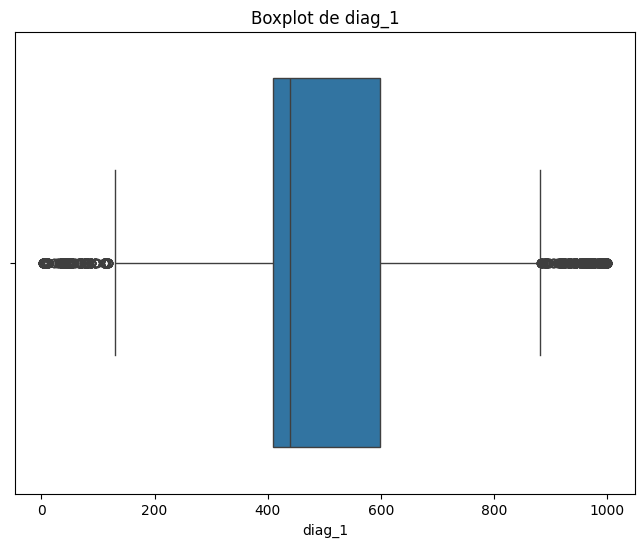

Q1: 296.0, Q3: 682.0, IQR: 386.0
Valores atípicos de diag_1:
[]


In [354]:
df_diabetes_numeric = pd.DataFrame()
df_diabetes_numeric['diag_1'] = pd.to_numeric(df_diabetes_cleaned['diag_1'], errors='coerce')


plt.figure(figsize=(8, 6))
sns.boxplot(x=df_diabetes_numeric['diag_1'])
plt.title('Boxplot de diag_1')
plt.show()

Q1 = df_diabetes_numeric['diag_1'].quantile(0.20)
Q3 = df_diabetes_numeric['diag_1'].quantile(0.80)
IQR = Q3 - Q1

print(f'Q1: {Q1}, Q3: {Q3}, IQR: {IQR}')

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

outliers_diag1 = df_diabetes_numeric[(df_diabetes_numeric['diag_1'] < lower_limit) | (df_diabetes_numeric['diag_1'] > upper_limit)]

print("Valores atípicos de diag_1:")
print(outliers_diag1['diag_1'].unique())

In [355]:
df_diabetes['diag_1'].value_counts(normalize=False)

diag_1
428    6862
414    6581
786    4016
410    3614
486    3508
       ... 
817       1
61        1
148       1
870       1
V51       1
Name: count, Length: 716, dtype: int64

In [356]:
conteo_diag_1 = df_diabetes_cleaned['diag_1'].value_counts()

conteo_diag_1_filtrado = conteo_diag_1[conteo_diag_1 <= 5]

cantidad_total = conteo_diag_1_filtrado.sum()

print(f"La cantidad total de registros con 5 o menos apariciones es: {cantidad_total}")
print(f"El porcentaje sobre el total de datos es: {cantidad_total /  len(df_diabetes)}")

La cantidad total de registros con 5 o menos apariciones es: 619
El porcentaje sobre el total de datos es: 0.00608258160878879


*Se decide quitar los registros con 5 o menos ocurrencias.*

In [357]:
registros_a_eliminar = conteo_diag_1_filtrado.index

df_diabetes_cleaned = df_diabetes_cleaned[~df_diabetes_cleaned['diag_1'].isin(registros_a_eliminar)]

In [358]:
df_diabetes_cleaned['diag_2'].value_counts(normalize=True)

diag_2
428    0.066631
276    0.066446
250    0.055276
427    0.050349
401    0.036926
         ...   
963    0.000010
915    0.000010
683    0.000010
944    0.000010
927    0.000010
Name: proportion, Length: 727, dtype: float64

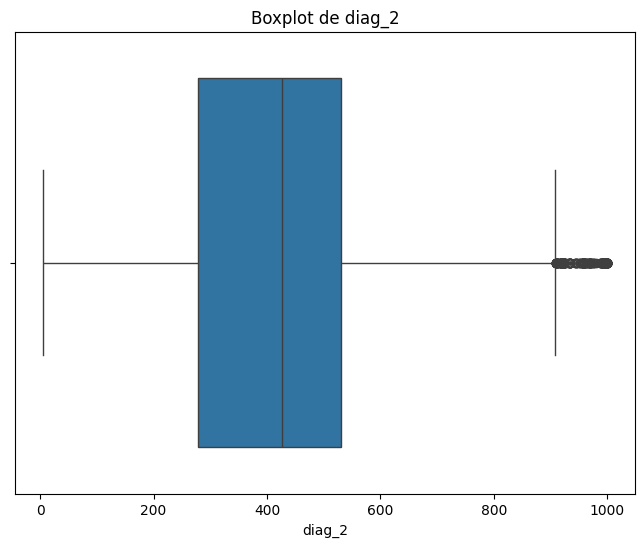

Valores atípicos de diag_2:
['440' '410' '428' '578' '250.6' '250.4' '250.32' '255' '997' '558' '599'
 '250.7' '402' '486' '414' '584' '682' '244' '250.03' '574' '577' '730'
 '786' '824' '562' '291' '276' '510' '401' '263' '434' '295' '438' '511'
 '427' '70' '722' '560' '182' '642' '491' '571' '250.42' '807' '250.13'
 '456' '518' '572' '575' '250.02' '820' '515' '780' '996' '995' '235'
 '250.8' '250.82' '721' '787' '724' '282' '250.83' 'V55' '281' '250.33'
 '530' '466' '296' '250.12' '998' '590' '715' 'V53' '593' '648' '566'
 '822' '191' '557' '432' '38' '435' '733' '403' '455' '482' '202' '493'
 '280' '789' '154' '250.22' '441' '250.81' '962' '592' '707' '728' '618'
 '426' '569' '386' '337' '82' '531' '812' '225' '596' 'V58' '656' '433'
 '573' '492' '808' '958' '196' '112' '823' '532' '346' '162' '453' '535'
 '250' '595' '211' '303' '218' '540' '189' '285' '198' '304' '157' '537'
 '250.31' '250.23' 'V57' '805' '507' '934' '376' '413' '153' '293' '626'
 '553' '411' '496' '340' '621' '2

In [359]:
df_diabetes_numeric['diag_2'] = pd.to_numeric(df_diabetes_cleaned['diag_2'], errors='coerce')

#df_diabetes_numeric = df_diabetes_numeric.dropna(subset=['diag_2'])

plt.figure(figsize=(8, 6))
sns.boxplot(x=df_diabetes_numeric['diag_2'])
plt.title('Boxplot de diag_2')
plt.show()

Q1 = df_diabetes_numeric['diag_2'].quantile(0.20)
Q3 = df_diabetes_numeric['diag_2'].quantile(0.80)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

outliers_diag2 = df_diabetes_numeric[(df_diabetes_numeric['diag_2'] < lower_limit) | (df_diabetes_numeric['diag_2'] > upper_limit)]

print("Valores atípicos de diag_2:")
print(outliers['diag_1'].unique())


In [360]:
df_diabetes_cleaned['diag_2'].value_counts(normalize=False)

diag_2
428    6478
276    6460
250    5374
427    4895
401    3590
       ... 
963       1
915       1
683       1
944       1
927       1
Name: count, Length: 727, dtype: int64

In [361]:
conteo_diag_2 = df_diabetes_cleaned['diag_2'].value_counts()

conteo_diag_2_filtrado = conteo_diag_2[conteo_diag_2 <= 5]

cantidad_total = conteo_diag_2_filtrado.sum()

print(f"La cantidad total de registros con 5 o menos apariciones es: {cantidad_total}")
print(f"El porcentaje sobre el total de datos es: {cantidad_total /  len(df_diabetes)}")

La cantidad total de registros con 5 o menos apariciones es: 631
El porcentaje sobre el total de datos es: 0.006200499184403435


*Se decide quitar los registros con 5 o menos ocurrencias.*

In [362]:
registros_a_eliminar = conteo_diag_2_filtrado.index

df_diabetes_cleaned = df_diabetes_cleaned[~df_diabetes['diag_2'].isin(registros_a_eliminar)]

C:\Users\marti\AppData\Local\Temp\ipykernel_14412\8806830.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_diabetes_cleaned = df_diabetes_cleaned[~df_diabetes['diag_2'].isin(registros_a_eliminar)]


In [363]:
df_diabetes_cleaned['diag_3'].value_counts(normalize=True)

diag_3
250     0.113830
401     0.082689
276     0.052210
428     0.046071
427     0.039735
          ...   
E815    0.000010
542     0.000010
E882    0.000010
E822    0.000010
971     0.000010
Name: proportion, Length: 768, dtype: float64

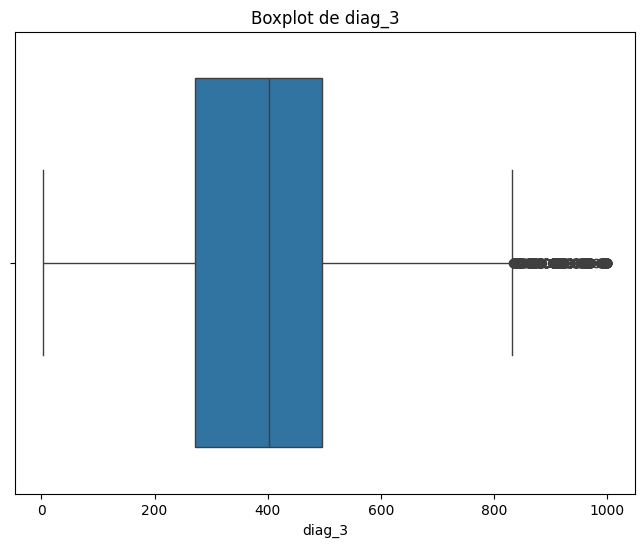

Valores atípicos de diag_3:
['440' '410' '428' '578' '250.6' '250.4' '250.32' '255' '997' '558' '599'
 '250.7' '402' '486' '414' '584' '682' '244' '250.03' '574' '577' '730'
 '786' '824' '562' '291' '276' '510' '401' '263' '434' '295' '438' '511'
 '427' '70' '722' '560' '182' '642' '491' '571' '250.42' '807' '250.13'
 '456' '518' '572' '575' '250.02' '820' '515' '780' '996' '995' '235'
 '250.8' '250.82' '721' '787' '724' '282' '250.83' 'V55' '281' '250.33'
 '530' '466' '296' '250.12' '998' '590' '715' 'V53' '593' '648' '566'
 '822' '191' '557' '432' '38' '435' '733' '403' '455' '482' '202' '493'
 '280' '789' '154' '250.22' '441' '250.81' '962' '592' '707' '728' '618'
 '426' '569' '386' '337' '82' '531' '812' '225' '596' 'V58' '656' '433'
 '573' '492' '808' '958' '196' '112' '823' '532' '346' '162' '453' '535'
 '250' '595' '211' '303' '218' '540' '189' '285' '198' '304' '157' '537'
 '250.31' '250.23' 'V57' '805' '507' '934' '376' '413' '153' '293' '626'
 '553' '411' '496' '340' '621' '2

In [364]:
df_diabetes_numeric['diag_3'] = pd.to_numeric(df_diabetes_cleaned['diag_3'], errors='coerce')

plt.figure(figsize=(8, 6))
sns.boxplot(x=df_diabetes_numeric['diag_3'])
plt.title('Boxplot de diag_3')
plt.show()

Q1 = df_diabetes_numeric['diag_3'].quantile(0.20)
Q3 = df_diabetes_numeric['diag_3'].quantile(0.80)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

outliers_diag3 = df_diabetes_numeric[(df_diabetes_numeric['diag_3'] < lower_limit) | (df_diabetes_numeric['diag_3'] > upper_limit)]

print("Valores atípicos de diag_3:")
print(outliers['diag_1'].unique())

In [365]:
df_diabetes_cleaned['diag_3'].value_counts(normalize=True)

diag_3
250     0.113830
401     0.082689
276     0.052210
428     0.046071
427     0.039735
          ...   
E815    0.000010
542     0.000010
E882    0.000010
E822    0.000010
971     0.000010
Name: proportion, Length: 768, dtype: float64

In [366]:
conteo_diag_3 = df_diabetes_cleaned['diag_3'].value_counts()

conteo_diag_3_filtrado = conteo_diag_3[conteo_diag_3 <= 5]

cantidad_total = conteo_diag_3_filtrado.sum()

print(f"La cantidad total de registros con 5 o menos apariciones es: {cantidad_total}")
print(f"El porcentaje sobre el total de datos es: {cantidad_total /  len(df_diabetes)}")

La cantidad total de registros con 5 o menos apariciones es: 696
El porcentaje sobre el total de datos es: 0.006839219385649431


In [367]:
registros_a_eliminar = conteo_diag_3_filtrado.index

df_diabetes_cleaned = df_diabetes_cleaned[~df_diabetes['diag_3'].isin(registros_a_eliminar)]

C:\Users\marti\AppData\Local\Temp\ipykernel_14412\1947161449.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_diabetes_cleaned = df_diabetes_cleaned[~df_diabetes['diag_3'].isin(registros_a_eliminar)]


In [368]:
print(len(df_diabetes_cleaned))

95895


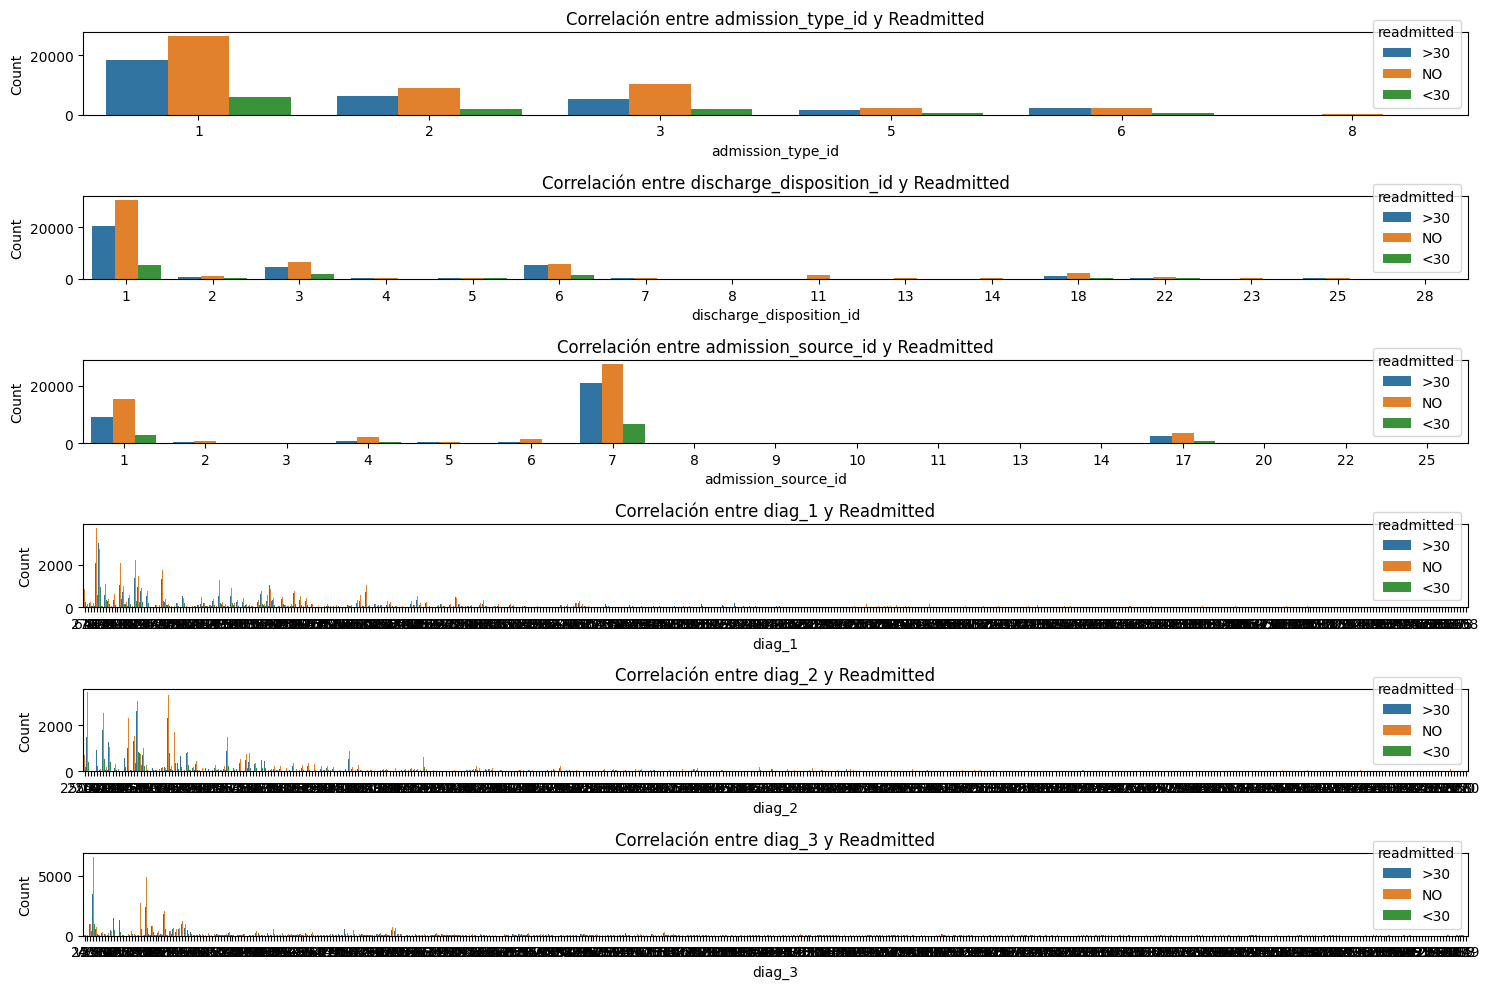

In [369]:
plt.figure(figsize=(15, 10))

for var in var_medicas:
    plt.subplot(6, 1, var_medicas.index(var) + 1)
    sns.countplot(x=var, hue='readmitted', data=df_diabetes_cleaned, dodge=True)
    plt.title(f'Correlación entre {var} y Readmitted')
    plt.xlabel(var)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

##### Analisis *var_medicine*

In [370]:
var_medicine = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 
                'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide',
                'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 
                'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']

In [371]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['metformin'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['metformin'].value_counts(normalize=False)}")


Porcentaje de valores unicos de: metformin
No        0.804432
Steady    0.179582
Up        0.010386
Down      0.005600
Name: proportion, dtype: float64
Cantidad de valores unicos de: metformin
No        77141
Steady    17221
Up          996
Down        537
Name: count, dtype: int64


In [372]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['repaglinide'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['repaglinide'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: repaglinide
No        0.984295
Steady    0.014140
Up        0.001095
Down      0.000469
Name: proportion, dtype: float64
Cantidad de valores unicos de: repaglinide
No        94389
Steady     1356
Up          105
Down         45
Name: count, dtype: int64


In [373]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['nateglinide'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['nateglinide'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: nateglinide
No        0.992919
Steady    0.006747
Up        0.000219
Down      0.000115
Name: proportion, dtype: float64
Cantidad de valores unicos de: nateglinide
No        95216
Steady      647
Up           21
Down         11
Name: count, dtype: int64


Se decide eliminar las filas con los datos Up y Down ya que no son representativos de la variable.

In [374]:
df_diabetes_cleaned = df_diabetes_cleaned[~df_diabetes_cleaned['nateglinide'].isin(['Up', 'Down'])]

In [375]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['chlorpropamide'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['chlorpropamide'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: chlorpropamide
No        0.999155
Steady    0.000772
Up        0.000063
Down      0.000010
Name: proportion, dtype: float64
Cantidad de valores unicos de: chlorpropamide
No        95782
Steady       74
Up            6
Down          1
Name: count, dtype: int64


Se decide quitar la variable chlorpropamide porque el 99,9% de sus datos tienen el mismo valor.

In [376]:
df_diabetes_cleaned = df_diabetes_cleaned.drop(['chlorpropamide'],axis=1)

In [377]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['glimepiride'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['glimepiride'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: glimepiride
No        0.949115
Steady    0.045742
Up        0.003255
Down      0.001888
Name: proportion, dtype: float64
Cantidad de valores unicos de: glimepiride
No        90985
Steady     4385
Up          312
Down        181
Name: count, dtype: int64


In [378]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['acetohexamide'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['acetohexamide'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: acetohexamide
No        0.99999
Steady    0.00001
Name: proportion, dtype: float64
Cantidad de valores unicos de: acetohexamide
No        95862
Steady        1
Name: count, dtype: int64


Se decide quitar la variable acetohexamide porque el 99,9% de sus datos tienen el mismo valor.

In [379]:
df_diabetes_cleaned = df_diabetes_cleaned.drop(['acetohexamide'],axis=1)

In [380]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['glipizide'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['glipizide'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: glipizide
No        0.874394
Steady    0.112369
Up        0.007657
Down      0.005581
Name: proportion, dtype: float64
Cantidad de valores unicos de: glipizide
No        83822
Steady    10772
Up          734
Down        535
Name: count, dtype: int64


In [381]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['glyburide'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['glyburide'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: glyburide
No        0.895038
Steady    0.091370
Up        0.008053
Down      0.005539
Name: proportion, dtype: float64
Cantidad de valores unicos de: glyburide
No        85801
Steady     8759
Up          772
Down        531
Name: count, dtype: int64


In [382]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['tolbutamide'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['tolbutamide'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: tolbutamide
No        0.999791
Steady    0.000209
Name: proportion, dtype: float64
Cantidad de valores unicos de: tolbutamide
No        95843
Steady       20
Name: count, dtype: int64


Se decide quitar la variable tolbutamide porque el 99,9% de sus datos tienen el mismo valor.

In [383]:
df_diabetes_cleaned = df_diabetes_cleaned.drop(['tolbutamide'],axis=1)

In [384]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['pioglitazone'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['pioglitazone'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: pioglitazone
No        0.927511
Steady    0.069015
Up        0.002285
Down      0.001189
Name: proportion, dtype: float64
Cantidad de valores unicos de: pioglitazone
No        88914
Steady     6616
Up          219
Down        114
Name: count, dtype: int64


In [385]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['rosiglitazone'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['rosiglitazone'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: rosiglitazone
No        0.936993
Steady    0.060367
Up        0.001773
Down      0.000866
Name: proportion, dtype: float64
Cantidad de valores unicos de: rosiglitazone
No        89823
Steady     5787
Up          170
Down         83
Name: count, dtype: int64


In [386]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['acarbose'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['acarbose'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: acarbose
No        0.996944
Steady    0.002921
Up        0.000104
Down      0.000031
Name: proportion, dtype: float64
Cantidad de valores unicos de: acarbose
No        95570
Steady      280
Up           10
Down          3
Name: count, dtype: int64


Se decide eliminar las filas con los datos Up y Down ya que no son representativos de la variable.

In [387]:
df_diabetes_cleaned = df_diabetes_cleaned[~df_diabetes_cleaned['acarbose'].isin(['Up', 'Down'])]

In [388]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['miglitol'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['miglitol'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: miglitol
No        0.999614
Steady    0.000323
Down      0.000042
Up        0.000021
Name: proportion, dtype: float64
Cantidad de valores unicos de: miglitol
No        95813
Steady       31
Down          4
Up            2
Name: count, dtype: int64


Se decide quitar la variable miglitol porque el 99,9% de sus datos tienen el mismo valor.

In [389]:
df_diabetes_cleaned = df_diabetes_cleaned.drop(['miglitol'],axis=1)

In [390]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['troglitazone'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['troglitazone'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: troglitazone
No        0.999969
Steady    0.000031
Name: proportion, dtype: float64
Cantidad de valores unicos de: troglitazone
No        95847
Steady        3
Name: count, dtype: int64


Se decide quitar la variable troglitazone porque el 99,9% de sus datos tienen el mismo valor.

In [391]:
df_diabetes_cleaned = df_diabetes_cleaned.drop(['troglitazone'], axis=1)

In [392]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['tolazamide'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['tolazamide'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: tolazamide
No        0.999614
Steady    0.000376
Up        0.000010
Name: proportion, dtype: float64
Cantidad de valores unicos de: tolazamide
No        95813
Steady       36
Up            1
Name: count, dtype: int64


Se decide quitar la variable tolazamide porque el 99,9% de sus datos tienen el mismo valor.

In [393]:
df_diabetes_cleaned = df_diabetes_cleaned.drop(['tolazamide'], axis=1)

In [394]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['examide'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['examide'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: examide
No    1.0
Name: proportion, dtype: float64
Cantidad de valores unicos de: examide
No    95850
Name: count, dtype: int64


Se decide quitar la variable examide porque el 99,9% de sus datos tienen el mismo valor.

In [395]:
df_diabetes_cleaned = df_diabetes_cleaned.drop(['examide'], axis=1)

In [396]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['citoglipton'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['citoglipton'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: citoglipton
No    1.0
Name: proportion, dtype: float64
Cantidad de valores unicos de: citoglipton
No    95850
Name: count, dtype: int64


Se decide quitar la variable citoglipton porque el 99,9% de sus datos tienen el mismo valor.

In [397]:
df_diabetes_cleaned = df_diabetes_cleaned.drop(['citoglipton'],axis=1)

In [398]:
df_diabetes['insulin'].value_counts(normalize=False)
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['insulin'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['insulin'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: insulin
No        0.468326
Steady    0.299238
Down      0.121377
Up        0.111059
Name: proportion, dtype: float64
Cantidad de valores unicos de: insulin
No        44889
Steady    28682
Down      11634
Up        10645
Name: count, dtype: int64


In [399]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['glyburide-metformin'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['glyburide-metformin'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: glyburide-metformin
No        0.993250
Steady    0.006667
Up        0.000052
Down      0.000031
Name: proportion, dtype: float64
Cantidad de valores unicos de: glyburide-metformin
No        95203
Steady      639
Up            5
Down          3
Name: count, dtype: int64


Se decide eliminar las filas con los datos Up y Down ya que no son representativos de la variable.

In [400]:
df_diabetes_cleaned = df_diabetes_cleaned[~df_diabetes_cleaned['glyburide-metformin'].isin(['Up', 'Down'])]

In [401]:
df_diabetes['glimepiride-pioglitazone'].value_counts(normalize=False)
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['glimepiride-pioglitazone'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['glimepiride-pioglitazone'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: glimepiride-pioglitazone
No        0.99999
Steady    0.00001
Name: proportion, dtype: float64
Cantidad de valores unicos de: glimepiride-pioglitazone
No        95841
Steady        1
Name: count, dtype: int64


Se decide quitar la variable glimepiride-pioglitazone porque el 99,9% de sus datos tienen el mismo valor.

In [402]:
df_diabetes_cleaned = df_diabetes_cleaned.drop(['glimepiride-pioglitazone'],axis=1)

In [403]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['metformin-rosiglitazone'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['metformin-rosiglitazone'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: metformin-rosiglitazone
No    1.0
Name: proportion, dtype: float64
Cantidad de valores unicos de: metformin-rosiglitazone
No    95842
Name: count, dtype: int64


Se decide quitar la variable metformin-rosiglitazone porque el 99,9% de sus datos tienen el mismo valor.

In [404]:
df_diabetes_cleaned = df_diabetes_cleaned.drop(['metformin-rosiglitazone'], axis=1)

In [405]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['metformin-pioglitazone'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['metformin-pioglitazone'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: metformin-pioglitazone
No        0.99999
Steady    0.00001
Name: proportion, dtype: float64
Cantidad de valores unicos de: metformin-pioglitazone
No        95841
Steady        1
Name: count, dtype: int64


Se decide quitar la variable metformin-pioglitazone porque el 99,9% de sus datos tienen el mismo valor.

In [406]:
df_diabetes_cleaned = df_diabetes_cleaned.drop(['metformin-pioglitazone'], axis=1)

In [407]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['change'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['change'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: change
No    0.538
Ch    0.462
Name: proportion, dtype: float64
Cantidad de valores unicos de: change
No    51563
Ch    44279
Name: count, dtype: int64


In [408]:
print(f"Porcentaje de valores unicos de: {df_diabetes_cleaned['diabetesMed'].value_counts(normalize=True)}")
print(f"Cantidad de valores unicos de: {df_diabetes_cleaned['diabetesMed'].value_counts(normalize=False)}")

Porcentaje de valores unicos de: diabetesMed
Yes    0.76888
No     0.23112
Name: proportion, dtype: float64
Cantidad de valores unicos de: diabetesMed
Yes    73691
No     22151
Name: count, dtype: int64


In [409]:
variables_iniciales = set(var_medicine)

columnas_df = set(df_diabetes_cleaned.columns)

variables_actuales = variables_iniciales.intersection(columnas_df)

print("Variables que aún existen en el DataFrame:", variables_actuales)
len(variables_actuales)

Variables que aún existen en el DataFrame: {'acarbose', 'metformin', 'glipizide-metformin', 'nateglinide', 'pioglitazone', 'rosiglitazone', 'glipizide', 'glimepiride', 'insulin', 'repaglinide', 'glyburide', 'diabetesMed', 'glyburide-metformin', 'change'}


14

In [410]:
var_medicine = ['nateglinide', 'diabetesMed', 'metformin', 'glyburide-metformin', 'rosiglitazone', 'glyburide', 'pioglitazone', 'glipizide', 
                'insulin', 'repaglinide', 'glimepiride', 'change', 'glipizide-metformin', 'acarbose']

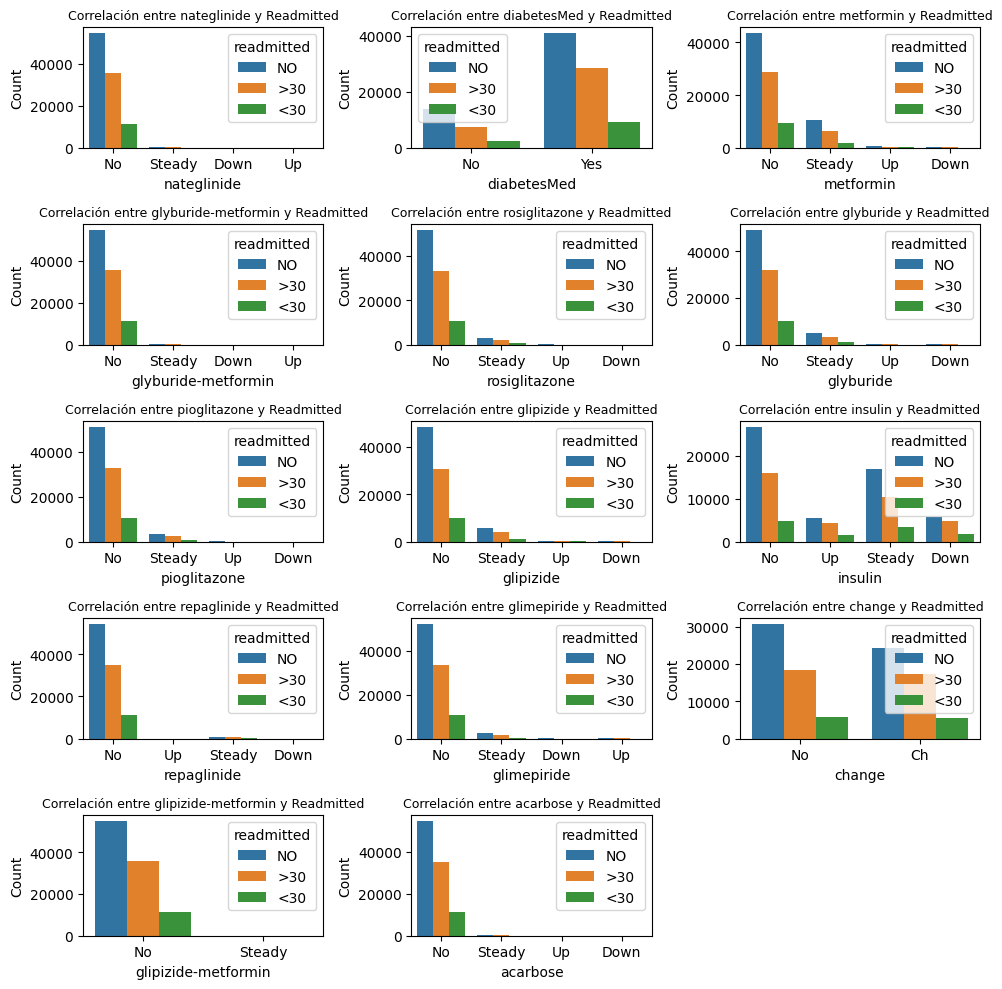

In [411]:
plt.figure(figsize=(10, 10))

for var in var_medicine:
    plt.subplot(5, 3, var_medicine.index(var) + 1)
    sns.countplot(x=var, hue='readmitted', data=df_diabetes, dodge=True)
    plt.title(f'Correlación entre {var} y Readmitted', fontsize=9)
    plt.xlabel(var)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

#### SELECCION DE FEATURES

# NO EJECUTAR ESTE CODIGO! SOLO INFO!!!!
0.47 entre "num_medications" y "time_in_hospital"  : en caso de dar de baja, mantener time in hospital SE PRUEBA Y NO MEJORA

ver outliers de diag HECHO

ver null de medicas ID HECHO

MODIFICAR NOMBRES DE MODELOS

In [412]:
df_diabetes_cleaned.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'metformin', 'repaglinide', 'nateglinide', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'insulin',
       'glyburide-metformin', 'glipizide-metformin', 'change', 'diabetesMed',
       'readmitted', 'readmitted_mapped'],
      dtype='object')

In [413]:
var_persona = ['race', 'gender', 'age']
var_numericas = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 
                'num_medications', 'number_outpatient', 'number_emergency', 
                'number_inpatient', 'number_diagnoses']
var_medicas = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
var_medicas_diag = ['diag_1', 'diag_2', 'diag_3']
var_medicine = ['nateglinide', 'diabetesMed', 'metformin', 'glyburide-metformin', 'rosiglitazone', 'glyburide', 'pioglitazone', 'glipizide', 
                'insulin', 'repaglinide', 'glimepiride', 'change', 'glipizide-metformin', 'acarbose']

var_objetivo = ['readmitted_mapped']

df_features = df_diabetes_cleaned[var_persona + var_numericas + var_medicas + var_medicas_diag + var_medicine + var_objetivo ].copy()

df_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95842 entries, 1 to 101765
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      95842 non-null  object
 1   gender                    95842 non-null  object
 2   age                       95842 non-null  object
 3   time_in_hospital          95842 non-null  int64 
 4   num_lab_procedures        95842 non-null  int64 
 5   num_procedures            95842 non-null  int64 
 6   num_medications           95842 non-null  int64 
 7   number_outpatient         95842 non-null  int64 
 8   number_emergency          95842 non-null  int64 
 9   number_inpatient          95842 non-null  int64 
 10  number_diagnoses          95842 non-null  int64 
 11  admission_type_id         95842 non-null  int64 
 12  discharge_disposition_id  95842 non-null  int64 
 13  admission_source_id       95842 non-null  int64 
 14  diag_1                    

##### ONE HOT ENCODING

Se aplica One Hot Encoding a las variables relacionadas a las personas.

In [414]:
df_features = pd.get_dummies(df_features, columns=var_persona)

In [415]:
df_features = pd.get_dummies(df_features, columns=var_medicas)

In [416]:
df_features = pd.get_dummies(df_features, columns=var_medicas_diag)

In [417]:
df_features = pd.get_dummies(df_features, columns=var_medicine)

In [418]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95842 entries, 1 to 101765
Columns: 1484 entries, time_in_hospital to acarbose_Steady
dtypes: bool(1475), int64(9)
memory usage: 142.1 MB


##### STANDARD SCALER

Se aplica standard scaler para manejar una misma escala con todas las variables numericas

In [419]:
scaler = StandardScaler()

df_features[var_numericas] = scaler.fit_transform(df_features[var_numericas])

print(df_features[var_numericas].head())

   time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
1         -0.476225            0.801029       -0.790270         0.228185   
2         -0.810146           -1.635027        2.128640        -0.387987   
3         -0.810146            0.039762       -0.206488        -0.018284   
4         -1.144067            0.395020       -0.790270        -1.004160   
5         -0.476225           -0.620003        2.712422        -0.018284   

   number_outpatient  number_emergency  number_inpatient  number_diagnoses  
1          -0.293217         -0.215466         -0.510259          0.810497  
2           1.261815         -0.215466          0.273802         -0.828729  
3          -0.293217         -0.215466         -0.510259         -0.282320  
4          -0.293217         -0.215466         -0.510259         -1.375137  
5          -0.293217         -0.215466         -0.510259          0.810497  


In [420]:
from sklearn.model_selection import train_test_split

X = df_features.drop('readmitted_mapped', axis=1)
y = df_features['readmitted_mapped']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [421]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

rf_1 = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=10,
    random_state=42
)

rf_1.fit(X_train, y_train)

y_pred_best_params = rf_1.predict(X_test)

# Calculo probabilidades predichas para AUC-ROC
y_pred_proba = rf_1.predict_proba(X_test)

auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print("Matriz de Confusión rf_1:")
print(confusion_matrix(y_test, y_pred_best_params))

print("\nReporte de Clasificación rf_1:")
print(classification_report(y_test, y_pred_best_params))

print(f'\nAUC-ROC: {auc_roc:.4f}')

Matriz de Confusión rf_1:
[[9681  566    0]
 [5541 1202    0]
 [1725  454    0]]

Reporte de Clasificación rf_1:
              precision    recall  f1-score   support

           1       0.57      0.94      0.71     10247
           2       0.54      0.18      0.27      6743
           3       0.00      0.00      0.00      2179

    accuracy                           0.57     19169
   macro avg       0.37      0.37      0.33     19169
weighted avg       0.50      0.57      0.47     19169


AUC-ROC: 0.6721


c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [422]:
feature_importances = rf_1.feature_importances_

num_features = sum(feature_importances > 0)

print(f"El modelo RandomForestClassifier tiene {num_features} features.")

El modelo RandomForestClassifier tiene 1470 features.


In [423]:
num_features = 1470

feature_importance = rf_1.feature_importances_
indices_ordenados = np.argsort(feature_importance)[::-1]
feature_importance_ordenada = feature_importance[indices_ordenados]
nombres_variables = X_train.columns

In [424]:
for i, feature in enumerate(X_train.columns):
    if(i<1471):
        print(f'Característica: {feature} - Importancia: {feature_importance_ordenada[i]}')

Característica: time_in_hospital - Importancia: 0.12477420489968769
Característica: num_lab_procedures - Importancia: 0.04285028106468555
Característica: num_procedures - Importancia: 0.04271991084693962
Característica: num_medications - Importancia: 0.036380772682554643
Característica: number_outpatient - Importancia: 0.03253602051931744
Característica: number_emergency - Importancia: 0.03148211370335053
Característica: number_inpatient - Importancia: 0.024635010443655247
Característica: number_diagnoses - Importancia: 0.01836039438501457
Característica: race_AfricanAmerican - Importancia: 0.015167064770187692
Característica: race_Asian - Importancia: 0.014638804617391407
Característica: race_Caucasian - Importancia: 0.01439028186946453
Característica: race_Hispanic - Importancia: 0.010660535239880715
Característica: race_Other - Importancia: 0.008679389111922935
Característica: gender_Female - Importancia: 0.008665580932331373
Característica: gender_Male - Importancia: 0.007892622306

Se mantienen solamente las features con un una importancia mayor a 0.3%.

Se genera un nuevo modelo (rf_2) solo con estas features.

In [425]:
features_to_keep = [feature for feature, importance in zip(X_train.columns, feature_importances) if importance >= 0.003]

X_train_filtered = X_train[features_to_keep]

X_test_filtered = X_test[features_to_keep]

rf_2 = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=10,
    random_state=42
)

rf_2.fit(X_train_filtered, y_train)

y_pred_filtered = rf_2.predict(X_test_filtered)

y_pred_proba_filtered = rf_2.predict_proba(X_test_filtered)

auc_roc_filtered = roc_auc_score(y_test, y_pred_proba_filtered, multi_class='ovr')

print("Matriz de Confusión (con características filtradas):")
print(confusion_matrix(y_test, y_pred_filtered))

print("\nReporte de Clasificación (con características filtradas):")
print(classification_report(y_test, y_pred_filtered))

print(f'\nAUC-ROC (con características filtradas): {auc_roc_filtered:.4f}')


Matriz de Confusión (con características filtradas):
[[8626 1613    8]
 [4229 2500   14]
 [1303  853   23]]

Reporte de Clasificación (con características filtradas):
              precision    recall  f1-score   support

           1       0.61      0.84      0.71     10247
           2       0.50      0.37      0.43      6743
           3       0.51      0.01      0.02      2179

    accuracy                           0.58     19169
   macro avg       0.54      0.41      0.38     19169
weighted avg       0.56      0.58      0.53     19169


AUC-ROC (con características filtradas): 0.6678


Se vuelve a correr el analisis de importancia de features, esta vez en el modelo rf_2.

In [426]:
feature_importances = rf_2.feature_importances_

num_features = sum(feature_importances > 0)

print(f"El modelo RandomForestClassifier tiene {num_features} features.")


El modelo RandomForestClassifier tiene 57 features.


In [427]:
num_features = 57

feature_importance = rf_2.feature_importances_
indices_ordenados = np.argsort(feature_importance)[::-1]
feature_importance_ordenada = feature_importance[indices_ordenados]
nombres_variables = X_train_filtered.columns

In [428]:
for i, feature in enumerate(X_train_filtered.columns):
    if(i<53):
        print(f'Característica: {feature} - Importancia: {feature_importance_ordenada[i]}')

Característica: time_in_hospital - Importancia: 0.1121036055120492
Característica: num_lab_procedures - Importancia: 0.09350001868329583
Característica: num_procedures - Importancia: 0.08349144935988002
Característica: num_medications - Importancia: 0.05918141109757151
Característica: number_outpatient - Importancia: 0.047623622160333744
Característica: number_emergency - Importancia: 0.04096012712182246
Característica: number_inpatient - Importancia: 0.035188533802737613
Característica: number_diagnoses - Importancia: 0.03445638445098612
Característica: race_AfricanAmerican - Importancia: 0.031456921225421035
Característica: race_Caucasian - Importancia: 0.01454571481385299
Característica: gender_Female - Importancia: 0.014215030440437674
Característica: gender_Male - Importancia: 0.014120538391417818
Característica: age_[40-50) - Importancia: 0.013936888613001621
Característica: age_[50-60) - Importancia: 0.013439491867910896
Característica: age_[60-70) - Importancia: 0.0128914628929

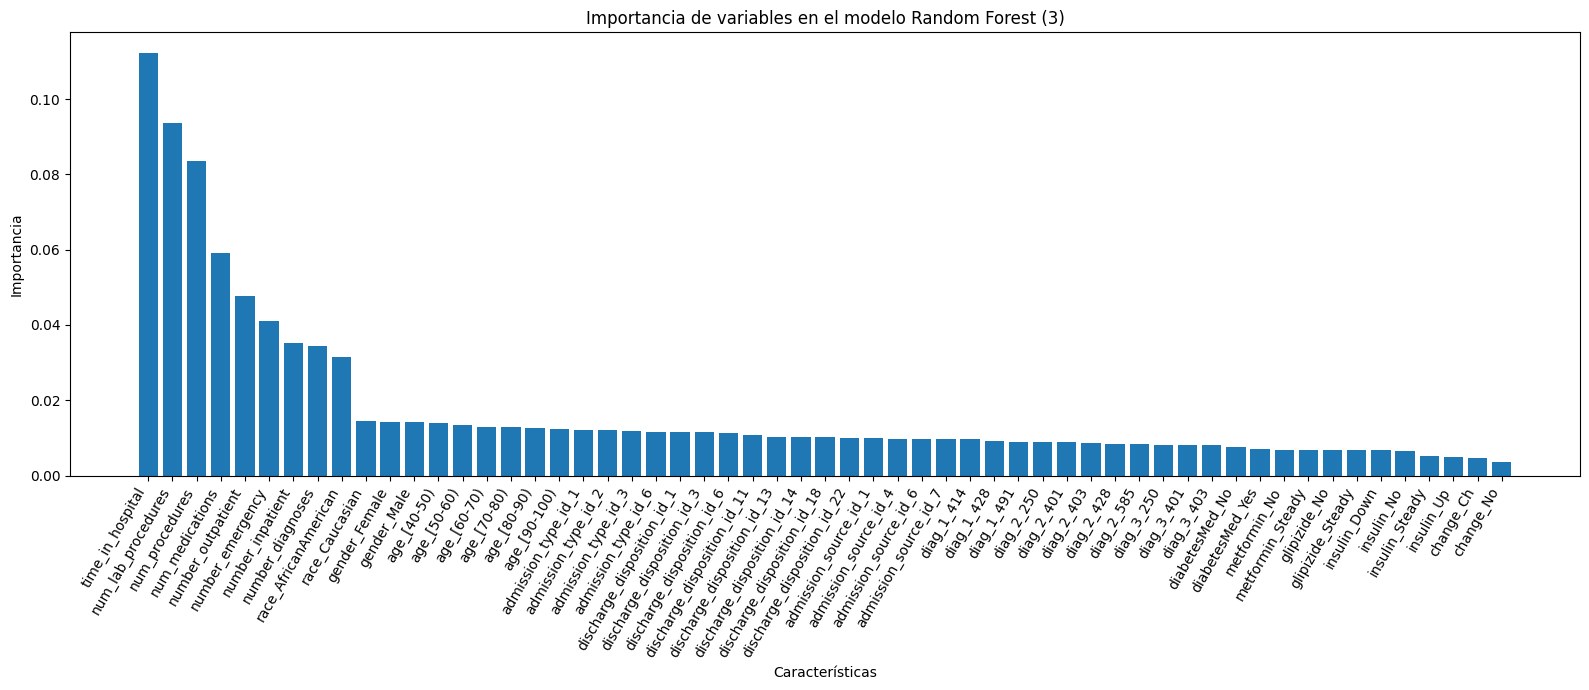

In [429]:
plt.figure(figsize=(16, 7))
plt.bar(range(len(nombres_variables)), feature_importance_ordenada)
plt.xticks(range(len(nombres_variables)), nombres_variables, rotation=60, ha='right')
plt.title('Importancia de variables en el modelo Random Forest (3)')
plt.xlabel('Características')
plt.ylabel('Importancia')

plt.tight_layout()
plt.show()

In [430]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

rf_grid = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(rf_grid, param_grid, cv=5)
grid_search.fit(X_train_filtered, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)

y_pred = grid_search.predict(X_test_filtered)

print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))


c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
2160 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2160 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\b

Mejores hiperparámetros: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
Matriz de Confusión:
[[8792 1453    2]
 [4424 2317    2]
 [1365  809    5]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.60      0.86      0.71     10247
           2       0.51      0.34      0.41      6743
           3       0.56      0.00      0.00      2179

    accuracy                           0.58     19169
   macro avg       0.55      0.40      0.37     19169
weighted avg       0.56      0.58      0.52     19169



*****************
------------------
****************

In [823]:
rf_model_weighted = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    class_weight='balanced'  # Ajustar pesos de clase automáticamente
)

rf_model_weighted.fit(X_train_filtered, y_train)

# Predecir en el conjunto de prueba
y_pred_weighted = rf_model_weighted.predict(X_test_filtered)

# Calcular AUC-ROC
y_pred_proba_weighted = rf_model_weighted.predict_proba(X_test_filtered)
auc_roc_weighted = roc_auc_score(y_test, y_pred_proba_weighted, multi_class='ovr')

# Imprimir métricas de rendimiento
print("Matriz de Confusión (con pesos de clase):")
print(confusion_matrix(y_test, y_pred_weighted))

print("\nReporte de Clasificación (con pesos de clase):")
print(classification_report(y_test, y_pred_weighted))

print(f'\nAUC-ROC (con pesos de clase): {auc_roc_weighted:.4f}')



Matriz de Confusión (con pesos de clase):
[[6776 1918 1920]
 [2763 2166 1901]
 [ 713  556  909]]

Reporte de Clasificación (con pesos de clase):
              precision    recall  f1-score   support

           1       0.66      0.64      0.65     10614
           2       0.47      0.32      0.38      6830
           3       0.19      0.42      0.26      2178

    accuracy                           0.50     19622
   macro avg       0.44      0.46      0.43     19622
weighted avg       0.54      0.50      0.51     19622


AUC-ROC (con pesos de clase): 0.6645


In [824]:
from imblearn.under_sampling import RandomUnderSampler

# Crear el objeto RandomUnderSampler
under_sampler = RandomUnderSampler(random_state=42)

# Aplicar submuestreo a los conjuntos de entrenamiento
X_train_undersampled, y_train_undersampled = under_sampler.fit_resample(X_train_filtered, y_train)

# Entrenar el modelo con el conjunto de entrenamiento submuestreado
rf_model_undersampled = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)

rf_model_undersampled.fit(X_train_undersampled, y_train_undersampled)

# Predecir en el conjunto de prueba
y_pred_undersampled = rf_model_undersampled.predict(X_test_filtered)

# Calcular AUC-ROC
y_pred_proba_undersampled = rf_model_undersampled.predict_proba(X_test_filtered)
auc_roc_undersampled = roc_auc_score(y_test, y_pred_proba_undersampled, multi_class='ovr')

# Imprimir métricas de rendimiento
print("Matriz de Confusión (con submuestreo):")
print(confusion_matrix(y_test, y_pred_undersampled))

print("\nReporte de Clasificación (con submuestreo):")
print(classification_report(y_test, y_pred_undersampled))

print(f'\nAUC-ROC (con submuestreo): {auc_roc_undersampled:.4f}')


Matriz de Confusión (con submuestreo):
[[6433 1995 2186]
 [2559 2103 2168]
 [ 654  530  994]]

Reporte de Clasificación (con submuestreo):
              precision    recall  f1-score   support

           1       0.67      0.61      0.64     10614
           2       0.45      0.31      0.37      6830
           3       0.19      0.46      0.26      2178

    accuracy                           0.49     19622
   macro avg       0.44      0.46      0.42     19622
weighted avg       0.54      0.49      0.50     19622


AUC-ROC (con submuestreo): 0.6627


In [826]:
from imblearn.over_sampling import SMOTE

# Crear el objeto SMOTE
smote = SMOTE(random_state=42)

# Aplicar sobremuestreo a los conjuntos de entrenamiento
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train_filtered, y_train)

# Entrenar el modelo con el conjunto de entrenamiento sobremuestreado
rf_model_oversampled = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    random_state=42
)

rf_model_oversampled.fit(X_train_oversampled, y_train_oversampled)

# Predecir en el conjunto de prueba
y_pred_oversampled = rf_model_oversampled.predict(X_test_filtered)

# Calcular AUC-ROC
y_pred_proba_oversampled = rf_model_oversampled.predict_proba(X_test_filtered)
auc_roc_oversampled = roc_auc_score(y_test, y_pred_proba_oversampled, multi_class='ovr')

# Imprimir métricas de rendimiento
print("Matriz de Confusión (con sobremuestreo):")
print(confusion_matrix(y_test, y_pred_oversampled))

print("\nReporte de Clasificación (con sobremuestreo):")
print(classification_report(y_test, y_pred_oversampled))

print(f'\nAUC-ROC (con sobremuestreo): {auc_roc_oversampled:.4f}')


Matriz de Confusión (con sobremuestreo):
[[7970 2384  260]
 [3507 3044  279]
 [ 992  964  222]]

Reporte de Clasificación (con sobremuestreo):
              precision    recall  f1-score   support

           1       0.64      0.75      0.69     10614
           2       0.48      0.45      0.46      6830
           3       0.29      0.10      0.15      2178

    accuracy                           0.57     19622
   macro avg       0.47      0.43      0.43     19622
weighted avg       0.54      0.57      0.55     19622


AUC-ROC (con sobremuestreo): 0.6589


In [827]:
from sklearn.ensemble import GradientBoostingClassifier

# Definir el modelo Gradient Boosting
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=10,
    random_state=42
)

# Entrenar el modelo en el conjunto de entrenamiento
gb_model.fit(X_train_filtered, y_train)

# Predecir en el conjunto de prueba
y_pred_gb = gb_model.predict(X_test_filtered)

# Calcular AUC-ROC
y_pred_proba_gb = gb_model.predict_proba(X_test_filtered)
auc_roc_gb = roc_auc_score(y_test, y_pred_proba_gb, multi_class='ovr')

# Imprimir métricas de rendimiento
print("Matriz de Confusión (Gradient Boosting):")
print(confusion_matrix(y_test, y_pred_gb))

print("\nReporte de Clasificación (Gradient Boosting):")
print(classification_report(y_test, y_pred_gb))

print(f'\nAUC-ROC (Gradient Boosting): {auc_roc_gb:.4f}')


Matriz de Confusión (Gradient Boosting):
[[8654 1880   80]
 [4106 2604  120]
 [1188  880  110]]

Reporte de Clasificación (Gradient Boosting):
              precision    recall  f1-score   support

           1       0.62      0.82      0.70     10614
           2       0.49      0.38      0.43      6830
           3       0.35      0.05      0.09      2178

    accuracy                           0.58     19622
   macro avg       0.49      0.42      0.41     19622
weighted avg       0.54      0.58      0.54     19622


AUC-ROC (Gradient Boosting): 0.6586


In [828]:
from sklearn.svm import SVC

# Definir el modelo SVM con kernel balanceado
svm_model = SVC(
    kernel='rbf',
    class_weight='balanced',
    random_state=42
)

# Entrenar el modelo en el conjunto de entrenamiento
svm_model.fit(X_train_filtered, y_train)

# Predecir en el conjunto de prueba
y_pred_svm = svm_model.predict(X_test_filtered)

# Imprimir métricas de rendimiento
print("Matriz de Confusión (SVM con kernel balanceado):")
print(confusion_matrix(y_test, y_pred_svm))

print("\nReporte de Clasificación (SVM con kernel balanceado):")
print(classification_report(y_test, y_pred_svm))


Matriz de Confusión (SVM con kernel balanceado):
[[6276 2537 1801]
 [2387 2765 1678]
 [ 615  700  863]]

Reporte de Clasificación (SVM con kernel balanceado):
              precision    recall  f1-score   support

           1       0.68      0.59      0.63     10614
           2       0.46      0.40      0.43      6830
           3       0.20      0.40      0.26      2178

    accuracy                           0.50     19622
   macro avg       0.45      0.46      0.44     19622
weighted avg       0.55      0.50      0.52     19622



In [829]:
print("Distribución de clases en el conjunto de prueba:")
print(y_test.value_counts())

Distribución de clases en el conjunto de prueba:
readmitted_mapped
1    10614
2     6830
3     2178
Name: count, dtype: int64


In [830]:
from imblearn.over_sampling import SMOTE

# Calcular la proporción de clases original
class_counts = y_train.value_counts()

# Definir el objetivo de sobremuestreo como un porcentaje de la clase mayoritaria
desired_percentage_of_majority = 1.0  # Puedes ajustar este valor según tus necesidades

# Calcular el número de instancias que deberían tener las clases minoritarias
desired_count_for_minorities = (class_counts.max() * desired_percentage_of_majority).astype(int)

# Crear el objeto SMOTE con el objetivo de sobremuestreo para las clases minoritarias
smote_minority = SMOTE(sampling_strategy={2: desired_count_for_minorities, 3: desired_count_for_minorities}, random_state=42)

# Aplicar sobremuestreo solo a la clase minoritaria en los conjuntos de entrenamiento
X_train_oversampled_minority, y_train_oversampled_minority = smote_minority.fit_resample(X_train_filtered, y_train)


In [832]:
rf_model_weighted = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    class_weight='balanced'  # Ajustar pesos de clase automáticamente
)

rf_model_weighted.fit(X_train_oversampled_minority, y_train_oversampled_minority)

# Predecir en el conjunto de prueba
y_pred_weighted = rf_model_weighted.predict(X_test_filtered)

# Calcular AUC-ROC
y_pred_proba_weighted = rf_model_weighted.predict_proba(X_test_filtered)
auc_roc_weighted = roc_auc_score(y_test, y_pred_proba_weighted, multi_class='ovr')

# Imprimir métricas de rendimiento
print("Matriz de Confusión (con pesos de clase):")
print(confusion_matrix(y_test, y_pred_weighted))

print("\nReporte de Clasificación (con pesos de clase):")
print(classification_report(y_test, y_pred_weighted))

print(f'\nAUC-ROC (con pesos de clase): {auc_roc_weighted:.4f}')

Matriz de Confusión (con pesos de clase):
[[7780 1902  932]
 [3422 2369 1039]
 [ 940  673  565]]

Reporte de Clasificación (con pesos de clase):
              precision    recall  f1-score   support

           1       0.64      0.73      0.68     10614
           2       0.48      0.35      0.40      6830
           3       0.22      0.26      0.24      2178

    accuracy                           0.55     19622
   macro avg       0.45      0.45      0.44     19622
weighted avg       0.54      0.55      0.54     19622


AUC-ROC (con pesos de clase): 0.6572


In [833]:
class_weights_manual = {1: 0.34, 2: 0.33, 3: 0.33}

# Crear el modelo con pesos de clase manuales
rf_model_manual_weights = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    class_weight=class_weights_manual
)

# Entrenar el modelo en los conjuntos de entrenamiento con pesos de clase manuales
rf_model_manual_weights.fit(X_train_oversampled_minority, y_train_oversampled_minority)

y_pred_proba_weighted = rf_model_manual_weights.predict_proba(X_test_filtered)
auc_roc_weighted = roc_auc_score(y_test, y_pred_proba_weighted, multi_class='ovr')

print("Matriz de Confusión (con pesos de clase):")
print(confusion_matrix(y_test, y_pred_weighted))

print("\nReporte de Clasificación (con pesos de clase):")
print(classification_report(y_test, y_pred_weighted))

print(f'\nAUC-ROC (con pesos de clase): {auc_roc_weighted:.4f}')

Matriz de Confusión (con pesos de clase):
[[7780 1902  932]
 [3422 2369 1039]
 [ 940  673  565]]

Reporte de Clasificación (con pesos de clase):
              precision    recall  f1-score   support

           1       0.64      0.73      0.68     10614
           2       0.48      0.35      0.40      6830
           3       0.22      0.26      0.24      2178

    accuracy                           0.55     19622
   macro avg       0.45      0.45      0.44     19622
weighted avg       0.54      0.55      0.54     19622


AUC-ROC (con pesos de clase): 0.6570


-------------------------------
-------------------------------


----------------------------------
---------------------------------

# APLICAR ESTRATEGIA DE STACKING USADA EN OBLIGATORIO DE MACHINE LEARNING

### INTENTAR USAR OTROS MODELOS

### PROBAR HACER UN MODELO DE DEEP LEARNING EN LUGAR DE USAR UN MODELO DE MACHINE LEARNING